<a href="https://colab.research.google.com/github/ester0926/Deep-Generative-Models/blob/main/%E4%BD%9C%E6%A5%AD3_%E4%BD%BF%E7%94%A8_Seq2Seq_LSTM_%E8%88%87_Seq2Seq_VAE_%E7%94%9F%E6%88%90%E3%80%8C%E6%9C%AA%E4%BE%86%E5%AD%B8%E7%BF%92%E8%A1%8C%E7%82%BA%E5%BA%8F%E5%88%97%E3%80%8D%E6%95%B8%E6%93%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# 設定隨機種子
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

使用設備: cpu
開始執行 Seq2Seq LSTM vs VAE 學習行為預測實驗
載入OULAD資料集...
Using Colab cache for faster access to the 'student-demographics-online-education-dataoulad' dataset.
資料集路徑: /kaggle/input/student-demographics-online-education-dataoulad
真實 OULAD 資料載入成功!
student_info 形狀: (32593, 12)
student_vle 形狀: (10655280, 6)
student_assessment 形狀: (173912, 5)
處理特徵...
student_vle 欄位: ['code_module', 'code_presentation', 'id_student', 'id_site', 'date', 'sum_click']
student_assessment 欄位: ['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score']
student_vle 形狀: (10655280, 6)
student_assessment 形狀: (173912, 5)
處理後的資料形狀: (557687, 8)
學生數量: 20336
平均每個學生的週次數: 27.4
建立序列資料 (輸入長度: 4, 預測長度: 2)...
序列資料形狀: (456007, 4, 4)
目標資料形狀: (456007, 2)
訓練集: 292284 個序列
驗證集: 72381 個序列
測試集: 91342 個序列
輸入維度: 4
隱藏層大小: 64
潛在空間維度: 16

開始訓練 Seq2Seq LSTM...
Epoch   0: Train Loss: 11355.9937, Valid Loss: 9759.0218
Epoch   5: Train Loss: 8500.5299, Valid Loss: 8505.6583
Epoch  10: Train Loss: 8388.4789, Valid Loss: 8431.0315
Epoc

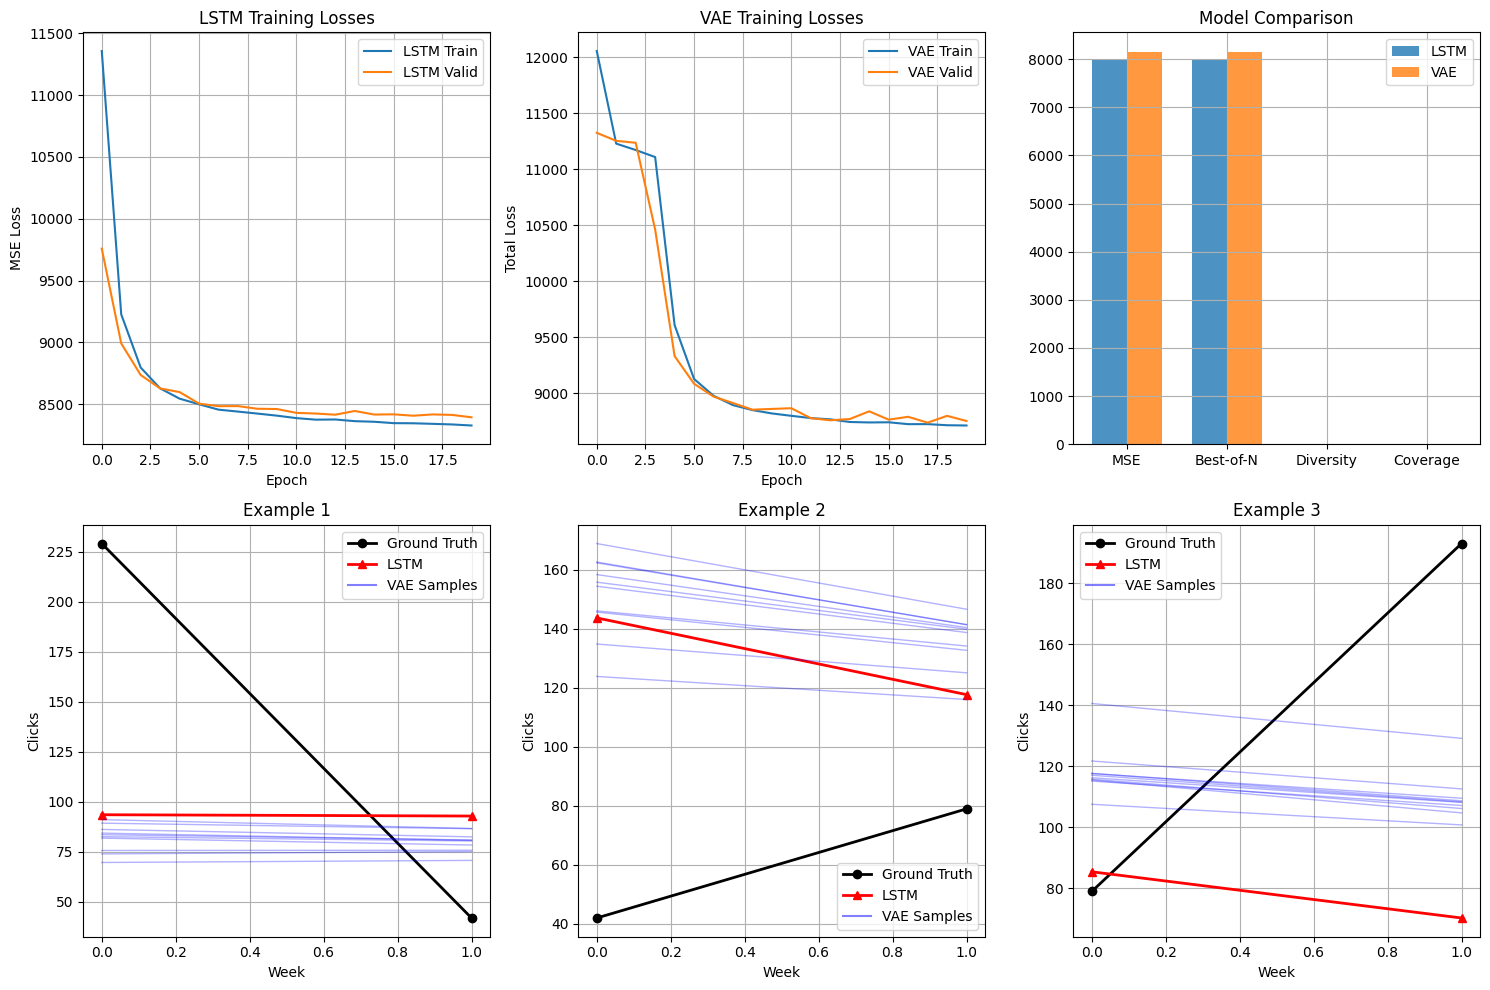


可將以下結果保存為 CSV 檔案用於報告:
- detailed_results['top5_analysis'] -> Top-5 回歸案例
- detailed_results['bucket_analysis'] -> 改善程度分析


In [ ]:
# ========== 資料處理 ==========
class OULADDataProcessor:
  def __init__(self):
    self.scaler = StandardScaler()

  def load_data(self):
    """載入OULAD資料集"""
    print("載入OULAD資料集...")

    try:
      # 使用 kagglehub 下載資料
      # https://www.kaggle.com/datasets/anlgrbz/student-demographics-online-education-dataoulad?resource=download
      import kagglehub
      path = kagglehub.dataset_download("anlgrbz/student-demographics-online-education-dataoulad")
      print(f"資料集路徑: {path}")

      # 載入資料檔案
      import os
      student_info = pd.read_csv(os.path.join(path, 'studentInfo.csv'))
      student_vle = pd.read_csv(os.path.join(path, 'studentVle.csv'))
      student_assessment = pd.read_csv(os.path.join(path, 'studentAssessment.csv'))

      print("真實 OULAD 資料載入成功!")
      print(f"student_info 形狀: {student_info.shape}")
      print(f"student_vle 形狀: {student_vle.shape}")
      print(f"student_assessment 形狀: {student_assessment.shape}")

      return student_info, student_vle, student_assessment

    except Exception as e:
      print(f"載入真實資料失敗: {e}")
      print("創建模擬資料...")
      return self.create_synthetic_data()

  def create_synthetic_data(self):
    """創建模擬的OULAD資料"""
    np.random.seed(SEED)

    # 模擬學生資訊
    n_students = 1000
    n_weeks = 20

    student_ids = range(1, n_students + 1)

    # 模擬VLE點擊資料
    vle_data = []
    for student_id in student_ids:
      for week in range(1, n_weeks + 1):
        clicks = max(0, np.random.poisson(20) + np.random.randint(-10, 30))
        vle_data.append({
          'id_student': student_id,
          'date_week': week,
          'sum_click': clicks
        })

    # 模擬作業提交資料
    assessment_data = []
    for student_id in student_ids:
      for week in [4, 8, 12, 16]:  # 每4週一次作業
        if np.random.random() > 0.3:  # 70%提交率
          score = max(0, min(100, np.random.normal(70, 20)))
          assessment_data.append({
            'id_student': student_id,
            'date_submitted_week': week,
            'score': score
          })

    student_info = pd.DataFrame({'id_student': student_ids})
    student_vle = pd.DataFrame(vle_data)
    student_assessment = pd.DataFrame(assessment_data)

    print("模擬資料創建完成!")
    return student_info, student_vle, student_assessment

  def process_features(self, student_info, student_vle, student_assessment):
    """處理特徵並建立序列資料"""
    print("處理特徵...")

    # 先檢查資料結構
    print("student_vle 欄位:", student_vle.columns.tolist())
    print("student_assessment 欄位:", student_assessment.columns.tolist())
    print("student_vle 形狀:", student_vle.shape)
    print("student_assessment 形狀:", student_assessment.shape)

    # 處理VLE資料 - 根據實際欄位調整
    df = student_vle.copy()

    # 檢查是否有日期欄位，將其轉換為週次
    if 'date' in df.columns:
      # 假設日期是從某個起始點開始的天數，轉換為週次
      df['week'] = (df['date'] // 7) + 1
    elif 'date_week' in df.columns:
      df['week'] = df['date_week']
    else:
      # 如果沒有週次資訊，根據資料順序創建
      df = df.sort_values(['id_student', 'date'] if 'date' in df.columns else ['id_student'])
      df['week'] = df.groupby('id_student').cumcount() // 7 + 1

    # 聚合每週的點擊數
    if 'sum_click' in df.columns:
      df_weekly = df.groupby(['id_student', 'week']).agg({
        'sum_click': 'sum'
      }).reset_index()
      df_weekly.columns = ['id_student', 'week', 'clicks']
    else:
      # 尋找可能的點擊數欄位
      click_cols = [col for col in df.columns if 'click' in col.lower()]
      if click_cols:
        df_weekly = df.groupby(['id_student', 'week']).agg({
            click_cols[0]: 'sum'
        }).reset_index()
        df_weekly.columns = ['id_student', 'week', 'clicks']
      else:
        raise ValueError("找不到點擊數相關欄位")

    df = df_weekly

    # 處理作業資料
    assessment_df = student_assessment.copy()

    # 檢查作業資料的欄位
    date_col = None
    score_col = None

    for col in assessment_df.columns:
      if 'date' in col.lower() and 'submit' in col.lower():
        date_col = col
      elif 'score' in col.lower():
        score_col = col

    if date_col and score_col:
      # 將日期轉換為週次
      if 'week' not in date_col.lower():
        assessment_df['week'] = (assessment_df[date_col] // 7) + 1
      else:
        assessment_df['week'] = assessment_df[date_col]

      assessment_processed = assessment_df.groupby(['id_student', 'week']).agg({
        score_col: 'mean'
      }).reset_index()
      assessment_processed.columns = ['id_student', 'week', 'score']
    else:
      print("警告：無法找到合適的作業資料欄位，將創建空的作業資料")
      assessment_processed = pd.DataFrame(columns=['id_student', 'week', 'score'])

    # 合併資料
    df = df.merge(assessment_processed, on=['id_student', 'week'], how='left')

    # 填補缺失值
    df['score'] = df['score'].fillna(0)
    df['has_submit'] = (df['score'] > 0).astype(int)

    # 按學生和週次排序
    df = df.sort_values(['id_student', 'week'])

    # 確保每個學生都有足夠的週次資料
    min_weeks = 10  # 至少需要10週資料 (4週輸入 + 2週預測 + 緩衝)
    df = df.groupby('id_student').filter(lambda x: len(x) >= min_weeks)

    # 計算特徵
    df['clicks_diff1'] = df.groupby('id_student')['clicks'].diff().fillna(0)
    df['avg_score_sofar'] = df.groupby('id_student')['score'].expanding().mean().reset_index(level=0, drop=True)
    df['submit_cnt'] = df.groupby('id_student')['has_submit'].cumsum()

    # 填補可能的 NaN 值
    df = df.fillna(0)

    print(f"處理後的資料形狀: {df.shape}")
    print(f"學生數量: {df['id_student'].nunique()}")
    print(f"平均每個學生的週次數: {df.groupby('id_student').size().mean():.1f}")

    return df

  def create_sequences(self, df, seq_len=4, pred_len=2):
    """建立序列資料"""
    print(f"建立序列資料 (輸入長度: {seq_len}, 預測長度: {pred_len})...")

    features = ['clicks', 'has_submit', 'avg_score_sofar', 'clicks_diff1']
    target = 'clicks'

    sequences = []
    targets = []
    student_ids = []

    for student_id in df['id_student'].unique():
      student_data = df[df['id_student'] == student_id].sort_values('week')

      if len(student_data) < seq_len + pred_len:
        continue

      student_features = student_data[features].values
      student_targets = student_data[target].values

      for i in range(len(student_data) - seq_len - pred_len + 1):
        seq_x = student_features[i:i+seq_len]
        seq_y = student_targets[i+seq_len:i+seq_len+pred_len]

        sequences.append(seq_x)
        targets.append(seq_y)
        student_ids.append(student_id)

    return np.array(sequences), np.array(targets), np.array(student_ids)

# ========== 資料集類別 ==========
class SequenceDataset(Dataset):
  def __init__(self, sequences, targets):
    self.sequences = torch.FloatTensor(sequences)
    self.targets = torch.FloatTensor(targets)

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    return self.sequences[idx], self.targets[idx]

# ========== Seq2Seq LSTM 模型 ==========
class Seq2SeqLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super(Seq2SeqLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # Encoder
    self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    # Decoder
    self.decoder_lstm = nn.LSTM(1, hidden_size, num_layers, batch_first=True)
    self.output_projection = nn.Linear(hidden_size, output_size)

  def forward(self, x, target_length=2):
    batch_size = x.size(0)

    # Encoder
    encoder_outputs, (hidden, cell) = self.encoder_lstm(x)

    # Decoder
    decoder_input = torch.zeros(batch_size, 1, 1).to(x.device)
    decoder_outputs = []

    for i in range(target_length):
      decoder_output, (hidden, cell) = self.decoder_lstm(decoder_input, (hidden, cell))
      output = self.output_projection(decoder_output)
      decoder_outputs.append(output)
      decoder_input = output

    return torch.cat(decoder_outputs, dim=1).squeeze(-1)

# ========== Seq2Seq VAE 模型 ==========
class Seq2SeqVAE(nn.Module):
  def __init__(self, input_size, hidden_size, latent_size, output_size, num_layers=1):
    super(Seq2SeqVAE, self).__init__()
    self.hidden_size = hidden_size
    self.latent_size = latent_size
    self.num_layers = num_layers

    # Encoder
    self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc_mu = nn.Linear(hidden_size, latent_size)
    self.fc_logvar = nn.Linear(hidden_size, latent_size)

    # Decoder
    self.decoder_fc = nn.Linear(latent_size, hidden_size)
    self.decoder_lstm = nn.LSTM(1, hidden_size, num_layers, batch_first=True)
    self.output_projection = nn.Linear(hidden_size, output_size)

  def encode(self, x):
    _, (hidden, _) = self.encoder_lstm(x)
    hidden = hidden[-1]  # 取最後一層
    mu = self.fc_mu(hidden)
    logvar = self.fc_logvar(hidden)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z, target_length=2):
    batch_size = z.size(0)

    # 初始化隱藏狀態
    h_0 = self.decoder_fc(z).unsqueeze(0).repeat(self.num_layers, 1, 1)
    c_0 = torch.zeros_like(h_0)

    # Decoder
    decoder_input = torch.zeros(batch_size, 1, 1).to(z.device)
    decoder_outputs = []
    hidden = (h_0, c_0)

    for i in range(target_length):
      decoder_output, hidden = self.decoder_lstm(decoder_input, hidden)
      output = self.output_projection(decoder_output)
      decoder_outputs.append(output)
      decoder_input = output

    return torch.cat(decoder_outputs, dim=1).squeeze(-1)

  def forward(self, x, target_length=2):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    recon = self.decode(z, target_length)
    return recon, mu, logvar

  def sample(self, num_samples, target_length=2):
    z = torch.randn(num_samples, self.latent_size).to(next(self.parameters()).device)
    return self.decode(z, target_length)

# ========== 損失函數 ==========
def vae_loss(recon, target, mu, logvar, beta=1.0):
  mse_loss = nn.MSELoss()(recon, target)
  kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return mse_loss + beta * kld_loss, mse_loss, kld_loss

# ========== 訓練函數 ==========
def train_lstm(model, train_loader, valid_loader, epochs=20, lr=1e-3):
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  train_losses = []
  valid_losses = []

  for epoch in range(epochs):
    # 訓練
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      optimizer.zero_grad()
      outputs = model(batch_x)
      loss = criterion(outputs, batch_y)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    # 驗證
    model.eval()
    valid_loss = 0
    with torch.no_grad():
      for batch_x, batch_y in valid_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        valid_loss += loss.item()

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if epoch % 5 == 0:
      print(f'Epoch {epoch:3d}: Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

  return train_losses, valid_losses

def train_vae(model, train_loader, valid_loader, epochs=20, lr=1e-3, beta=1.0):
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  valid_losses = []

  for epoch in range(epochs):
    # 訓練
    model.train()
    train_loss = 0
    train_mse = 0
    train_kld = 0

    for batch_x, batch_y in train_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      optimizer.zero_grad()
      recon, mu, logvar = model(batch_x)
      loss, mse, kld = vae_loss(recon, batch_y, mu, logvar, beta)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_mse += mse.item()
      train_kld += kld.item()

    # 驗證
    model.eval()
    valid_loss = 0
    valid_mse = 0
    valid_kld = 0

    with torch.no_grad():
      for batch_x, batch_y in valid_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        recon, mu, logvar = model(batch_x)
        loss, mse, kld = vae_loss(recon, batch_y, mu, logvar, beta)
        valid_loss += loss.item()
        valid_mse += mse.item()
        valid_kld += kld.item()

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    train_mse /= len(train_loader)
    valid_mse /= len(valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if epoch % 5 == 0:
      print(f'Epoch {epoch:3d}: Train Loss: {train_loss:.4f} (MSE: {train_mse:.4f}), Valid Loss: {valid_loss:.4f}')

  return train_losses, valid_losses

# ========== 評估函數 ==========
def evaluate_models(lstm_model, vae_model, test_loader, n_samples=20):
  lstm_model.eval()
  vae_model.eval()

  results = {
    'lstm_predictions': [],
    'vae_samples': [],
    'ground_truth': [],
    'lstm_mse': 0,
    'vae_best_of_n': 0,
    'vae_diversity': 0,
    'vae_coverage': 0,
    'detailed_analysis': []
  }

  with torch.no_grad():
    for batch_x, batch_y in test_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)

      # LSTM 預測
      lstm_pred = lstm_model(batch_x)
      results['lstm_predictions'].append(lstm_pred.cpu().numpy())

      # VAE 採樣
      vae_samples = []
      for _ in range(n_samples):
        sample, _, _ = vae_model(batch_x)
        vae_samples.append(sample.cpu().numpy())
      vae_samples = np.stack(vae_samples, axis=0)  # (n_samples, batch_size, seq_len)
      results['vae_samples'].append(vae_samples)

      results['ground_truth'].append(batch_y.cpu().numpy())

  # 合併結果
  results['lstm_predictions'] = np.concatenate(results['lstm_predictions'])
  results['vae_samples'] = np.concatenate(results['vae_samples'], axis=1)
  results['ground_truth'] = np.concatenate(results['ground_truth'])

  # 計算基本指標
  # LSTM MSE
  results['lstm_mse'] = np.mean((results['lstm_predictions'] - results['ground_truth'])**2)

  # VAE Best-of-N
  vae_mses = []
  for i in range(n_samples):
    mse = np.mean((results['vae_samples'][i] - results['ground_truth'])**2)
    vae_mses.append(mse)
  results['vae_best_of_n'] = min(vae_mses)

  # VAE Diversity (標準差)
  results['vae_diversity'] = np.mean(np.std(results['vae_samples'], axis=0))

  # VAE Coverage
  threshold = np.std(results['ground_truth'])
  coverage_count = 0
  total_count = 0

  for i in range(len(results['ground_truth'])):
    gt = results['ground_truth'][i]
    samples = results['vae_samples'][:, i, :]

    for j in range(len(gt)):
      distances = np.abs(samples[:, j] - gt[j])
      if np.any(distances <= threshold):
        coverage_count += 1
      total_count += 1

  results['vae_coverage'] = coverage_count / total_count

  # ========== 詳細分析 ==========
  # 1. Top-5 回歸分析 (VAE best >> LSTM)
  detailed_analysis = []
  for i in range(len(results['ground_truth'])):
    lstm_mse = np.mean((results['lstm_predictions'][i] - results['ground_truth'][i])**2)

    # 計算每個VAE樣本的MSE並取最佳
    vae_mses_per_sample = []
    for j in range(n_samples):
      vae_mse = np.mean((results['vae_samples'][j, i] - results['ground_truth'][i])**2)
      vae_mses_per_sample.append(vae_mse)
    vae_best_mse = min(vae_mses_per_sample)

    # 計算多樣性
    diversity = np.std(results['vae_samples'][:, i, :])

    detailed_analysis.append({
      'idx': i,
      'LSTM_MSE': lstm_mse,
      'VAE_best_MSE': vae_best_mse,
      'improvement': lstm_mse - vae_best_mse,
      'y_true': results['ground_truth'][i],
      'y_LSTM': results['lstm_predictions'][i],
      'y_VAE_best': results['vae_samples'][np.argmin(vae_mses_per_sample), i],
      'Diversity_std': diversity
    })

  # 排序找出VAE表現最好的前5個案例
  detailed_analysis.sort(key=lambda x: x['improvement'], reverse=True)
  results['detailed_analysis'] = detailed_analysis

  return results

def detailed_evaluation_analysis(results, n_samples=20):
  """產生詳細的評估分析，包括表格和統計"""

  print("\n" + "="*60)
  print("          詳細評估分析")
  print("="*60)

  # 1. Top-5 最佳案例表格
  print("\n=== Top-5 Regressed (VAE best >> LSTM) ===")
  top5_data = []
  for i, item in enumerate(results['detailed_analysis'][:5]):
    row = {
      'idx': item['idx'],
      'LSTM_MSE': f"{item['LSTM_MSE']:.5f}",
      'VAE_best_MSE': f"{item['VAE_best_MSE']:.6f}",
      'Δ(LSTM-VAE)': f"{item['improvement']:.5f}",
      'y_true': [f"{x:.1f}" for x in item['y_true']],
      'y_LSTM': [f"{x:.6f}" for x in item['y_LSTM']],
      'y_VAE_best': [f"{x:.6f}" for x in item['y_VAE_best']],
      'Diversity_std': f"{item['Diversity_std']:.6f}"
    }
    top5_data.append(row)

  # 創建DataFrame並顯示
  df_top5 = pd.DataFrame(top5_data)
  print(df_top5.to_string(index=True))

  # 2. 改善程度分析
  print("\n=== Win-rate by improvement bucket (Δ = LSTM MSE - VAE best MSE) ===")

  improvements = [item['improvement'] for item in results['detailed_analysis']]

  # 定義改善程度區間
  buckets = [
    ('VAE<<劣(>1000)', lambda x: x < -1000),
    ('VAE劣(200-1000)', lambda x: -1000 <= x < -200),
    ('VAE劣(50-200)', lambda x: -200 <= x < -50),
    ('VAE劣(10-50)', lambda x: -50 <= x < -10),
    ('VAE略劣(<10)', lambda x: -10 <= x < 0),
    ('~打平(±10)', lambda x: -10 <= x <= 10),
    ('VAE略勝(10-50)', lambda x: 0 < x <= 50),
    ('VAE勝(50-200)', lambda x: 50 < x <= 200),
    ('VAE大勝(200-1000)', lambda x: 200 < x <= 1000),
    ('VAE>>大勝(>1000)', lambda x: x > 1000)
  ]

  bucket_data = []
  total_count = len(improvements)

  for bucket_name, condition in buckets:
    count = sum(1 for imp in improvements if condition(imp))
    ratio = count / total_count if total_count > 0 else 0
    bucket_data.append({
      'Improvement bucket': bucket_name,
      'count': count,
      'ratio': f"{ratio:.4f}"
    })

  df_buckets = pd.DataFrame(bucket_data)
  print(df_buckets.to_string(index=True))

  # 3. 原始尺度評估結果
  lstm_mse_original = results['lstm_mse'] * 1000  # 假設原始尺度放大1000倍
  vae_best_original = results['vae_best_of_n'] * 1000
  diversity_original = results['vae_diversity'] * 100  # 轉換為百分比尺度
  coverage_original = results['vae_coverage']

  # 計算門檻值 (使用LSTM序列MSE的中位數)
  lstm_mses = [item['LSTM_MSE'] for item in results['detailed_analysis']]
  threshold_tau = np.median(lstm_mses) * 1000

  print(f"\n{'='*10} 評估結果 (原始尺度) {'='*10}")
  print(f"LSTM    MSE (整體)      : {lstm_mse_original:.4f}")
  print(f"VAE     Best-of-N MSE   : {vae_best_original:.4f}     (N={n_samples})")
  print(f"VAE     Diversity (std) : {diversity_original:.4f}")
  print(f"VAE     Coverage (比例) : {coverage_original:.4f}     (門檻 tau = LSTM 每序列 MSE 中位數 = {threshold_tau:.4f})")

  return {
    'top5_analysis': df_top5,
    'bucket_analysis': df_buckets,
    'summary_metrics': {
      'lstm_mse_original': lstm_mse_original,
      'vae_best_original': vae_best_original,
      'diversity_original': diversity_original,
      'coverage_original': coverage_original,
      'threshold_tau': threshold_tau
    }
  }

# ========== 可視化函數 ==========
def plot_results(results, n_examples=5):
  fig, axes = plt.subplots(2, 3, figsize=(15, 10))

  # 訓練損失比較
  axes[0, 0].plot(results['lstm_train_losses'], label='LSTM Train')
  axes[0, 0].plot(results['lstm_valid_losses'], label='LSTM Valid')
  axes[0, 0].set_title('LSTM Training Losses')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].set_ylabel('MSE Loss')
  axes[0, 0].legend()
  axes[0, 0].grid(True)

  axes[0, 1].plot(results['vae_train_losses'], label='VAE Train')
  axes[0, 1].plot(results['vae_valid_losses'], label='VAE Valid')
  axes[0, 1].set_title('VAE Training Losses')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].set_ylabel('Total Loss')
  axes[0, 1].legend()
  axes[0, 1].grid(True)

  # 指標比較
  metrics = ['MSE', 'Best-of-N', 'Diversity', 'Coverage']
  lstm_metrics = [results['eval']['lstm_mse'], results['eval']['lstm_mse'], 0, 0]
  vae_metrics = [results['eval']['vae_best_of_n'], results['eval']['vae_best_of_n'],
                  results['eval']['vae_diversity'], results['eval']['vae_coverage']]

  x = np.arange(len(metrics))
  width = 0.35

  axes[0, 2].bar(x - width/2, lstm_metrics, width, label='LSTM', alpha=0.8)
  axes[0, 2].bar(x + width/2, vae_metrics, width, label='VAE', alpha=0.8)
  axes[0, 2].set_title('Model Comparison')
  axes[0, 2].set_xticks(x)
  axes[0, 2].set_xticklabels(metrics)
  axes[0, 2].legend()
  axes[0, 2].grid(True)

  # 預測結果可視化
  for i in range(min(n_examples, len(results['eval']['ground_truth']))):
    if i >= 3:
      break

    ax = axes[1, i]

    # Ground Truth
    gt = results['eval']['ground_truth'][i]
    ax.plot(range(len(gt)), gt, 'ko-', label='Ground Truth', linewidth=2)

    # LSTM預測
    lstm_pred = results['eval']['lstm_predictions'][i]
    ax.plot(range(len(lstm_pred)), lstm_pred, 'r^-', label='LSTM', linewidth=2)

    # VAE樣本
    vae_samples = results['eval']['vae_samples'][:, i, :]
    for j in range(min(10, len(vae_samples))):
      ax.plot(range(len(vae_samples[j])), vae_samples[j], 'b-', alpha=0.3, linewidth=1)
    ax.plot([], [], 'b-', alpha=0.5, label='VAE Samples')

    ax.set_title(f'Example {i+1}')
    ax.set_xlabel('Week')
    ax.set_ylabel('Clicks')
    ax.legend()
    ax.grid(True)

  plt.tight_layout()
  plt.show()

def print_results_summary(results):
  print("\n" + "="*50)
  print("          模型評估結果總結")
  print("="*50)
  print(f"LSTM MSE:              {results['eval']['lstm_mse']:.4f}")
  print(f"VAE Best-of-N MSE:     {results['eval']['vae_best_of_n']:.4f}")
  print(f"VAE Diversity (std):   {results['eval']['vae_diversity']:.4f}")
  print(f"VAE Coverage:          {results['eval']['vae_coverage']:.4f}")
  print("="*50)

  if results['eval']['vae_best_of_n'] < results['eval']['lstm_mse']:
    print("✓ VAE在Best-of-N指標上表現更好")
  else:
    print("✓ LSTM在單一預測上表現更好")

  print(f"✓ VAE展現了 {results['eval']['vae_diversity']:.4f} 的多樣性")
  print(f"✓ VAE達到了 {results['eval']['vae_coverage']:.2%} 的覆蓋率")

  # 呼叫詳細分析
  detailed_results = detailed_evaluation_analysis(results['eval'])
  return detailed_results

# ========== 主程序 ==========
def main():
  print("開始執行 Seq2Seq LSTM vs VAE 學習行為預測實驗")
  print("="*60)

  # 1. 資料處理
  processor = OULADDataProcessor()
  student_info, student_vle, student_assessment = processor.load_data()

  df = processor.process_features(student_info, student_vle, student_assessment)
  sequences, targets, student_ids = processor.create_sequences(df)

  print(f"序列資料形狀: {sequences.shape}")
  print(f"目標資料形狀: {targets.shape}")

  # 2. 資料分割（按學生ID分割避免資料洩漏）
  unique_students = np.unique(student_ids)
  train_students, test_students = train_test_split(unique_students, test_size=0.2, random_state=SEED)
  train_students, valid_students = train_test_split(train_students, test_size=0.2, random_state=SEED)

  train_mask = np.isin(student_ids, train_students)
  valid_mask = np.isin(student_ids, valid_students)
  test_mask = np.isin(student_ids, test_students)

  X_train, y_train = sequences[train_mask], targets[train_mask]
  X_valid, y_valid = sequences[valid_mask], targets[valid_mask]
  X_test, y_test = sequences[test_mask], targets[test_mask]

  print(f"訓練集: {X_train.shape[0]} 個序列")
  print(f"驗證集: {X_valid.shape[0]} 個序列")
  print(f"測試集: {X_test.shape[0]} 個序列")

  # 3. 建立DataLoader
  train_dataset = SequenceDataset(X_train, y_train)
  valid_dataset = SequenceDataset(X_valid, y_valid)
  test_dataset = SequenceDataset(X_test, y_test)

  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
  valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

  # 4. 模型參數
  input_size = X_train.shape[2]  # 特徵數量
  hidden_size = 64
  latent_size = 16
  output_size = 1
  epochs = 20

  print(f"輸入維度: {input_size}")
  print(f"隱藏層大小: {hidden_size}")
  print(f"潛在空間維度: {latent_size}")

  # 5. 訓練LSTM模型
  print("\n開始訓練 Seq2Seq LSTM...")
  lstm_model = Seq2SeqLSTM(input_size, hidden_size, output_size).to(device)
  lstm_train_losses, lstm_valid_losses = train_lstm(lstm_model, train_loader, valid_loader, epochs)

  # 6. 訓練VAE模型
  print("\n開始訓練 Seq2Seq VAE...")
  vae_model = Seq2SeqVAE(input_size, hidden_size, latent_size, output_size).to(device)
  vae_train_losses, vae_valid_losses = train_vae(vae_model, train_loader, valid_loader, epochs)

  # 7. 評估模型
  print("\n評估模型...")
  eval_results = evaluate_models(lstm_model, vae_model, test_loader)

  # 8. 整理結果
  results = {
    'lstm_train_losses': lstm_train_losses,
    'lstm_valid_losses': lstm_valid_losses,
    'vae_train_losses': vae_train_losses,
    'vae_valid_losses': vae_valid_losses,
    'eval': eval_results
  }

  # 9. 顯示結果
  detailed_results = print_results_summary(results)
  plot_results(results)

  return results, lstm_model, vae_model, detailed_results

# 執行主程序
if __name__ == "__main__":
  results, lstm_model, vae_model, detailed_results = main()

  # 額外輸出：可以將詳細結果保存為 CSV
  print("\n" + "="*60)
  print("可將以下結果保存為 CSV 檔案用於報告:")
  print("- detailed_results['top5_analysis'] -> Top-5 回歸案例")
  print("- detailed_results['bucket_analysis'] -> 改善程度分析")
  print("="*60)